In [1]:
%%capture
make install-sys-packages 
make install-python-packages

In [5]:
%%capture
make download-data-from-google-drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tabulate import tabulate
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from skimage.filters import sobel 
from numpy.lib.type_check import imag
import random
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_validate
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score,confusion_matrix, make_scorer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import string
import time
from gtts import gTTS
from IPython.display import Audio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from boto3 import Session
from botocore.exceptions import BotoCoreError, ClientError
from contextlib import closing
import os
import sys
import subprocess
from tempfile import gettempdir
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

In [7]:
np.random.seed(2022)

In [8]:
# Extract word from line

# INPUT: 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n'
# OUTPUT: 'stop'

def get_word(line):
  return " ".join(line.split("\n")[0].split(" ")[8:]).strip()

In [9]:
# Returns a list of all words, each word has list of occurences

# INPUT:   # each line contains image and word info
# 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n',
# 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n',
# 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell\n',

# OUTPUT:  # each word has list of corresponding image info
# unique_words
# 'Sea': ['a02-027-08-00 ok 184 351 2328 121 74 NPL Sea',
#         'c02-017-06-07 ok 191 1913 2006 122 67 NPL Sea'],
# 'professes': ['a02-027-08-05 ok 184 1153 2333 280 90 VBZ professes'],
# 'return': ['a02-027-09-01 ok 183 568 2528 213 64 VB return',

# counter_input_data
#  'A',
#  'MOVE',
#  'to',

def get_unique_words_and_counter(file_path):
  unique_words = defaultdict(list)
  counter_input_data = []
  word_file = open(file_path, "r").readlines()
  for line in word_file:
      if line[0] == "#": # lines that start with # are comments and don't contain information about words
          continue
      if line.split(" ")[1] != "err": # err means word may not be segmented correctly
          word = get_word(line)
          unique_words[word].append(line.strip())
          counter_input_data.append(word)
  return unique_words,counter_input_data

In [10]:
# # most_common_words
# [('the', 4986),
#  (',', 4376),
#  ('.', 4094),
#  ('of', 2741),

# list containing n images of m most common words
# n: max_images_per_word
# m: max_words

# OUTPUT:
# ['a01-000u-04-05 ok 157 1665 1476 167 61 ATI the',
#  'a01-000x-03-07 ok 179 1650 1285 69 78 ATI the',

def filter_labels(most_common_words,unique_words,max_words,max_images_per_word): 
  filtered_labels = []
  num_word = 0
  for word,size in most_common_words:
    flag = False
    for char in word: # only continue if word contains any alphabet characters
      if char in string.ascii_letters:
        flag=True
        break
    if flag:
      if num_word < max_words:
        if size >= max_images_per_word: # only consider words with num images > max_images
            filtered_labels.extend(unique_words[word][0:max_images_per_word])
            num_word+=1
      else:
        break        
  return filtered_labels

In [11]:
# Filtered list of words by given list and max images per word

def get_labels_for_the_words(unique_words,words,max_images_per_word):
  labels = []
  for word in unique_words:
    if word in words:
      labels.extend(unique_words[word][0:max_images_per_word])
  return labels

In [12]:
# Filtered list of words by given list and max images per word

# INPUT:
# train_words
# {'backed','be','by','down','for','from','has','he','is'}

def get_input_for_labels_based_on_training_words(file_path,train_words,max_images_per_word):
  unique_words,counter_input_data = get_unique_words_and_counter(file_path)
  input_for_labels = get_labels_for_the_words(unique_words,train_words,max_images_per_word)
  return input_for_labels

In [13]:
# Filtered list of words by max number of words and max images per word

# counter_data
# 'A': 143,
# 'MOVE': 2,
# 'to': 2255,

# most_common_words
# [('the', 4986),
#  (',', 4376),
#  ('.', 4094),
#  ('of', 2741),

# OUTPUT: 
# input_for_labels (filtered list of words and images we will use)
# ['a01-000u-04-05 ok 157 1665 1476 167 61 ATI the',
#  'a01-000x-03-07 ok 179 1650 1285 69 78 ATI the',

def get_input_for_labels_based_max_size(file_path,max_words=50,max_images_per_word=100):
  unique_words,counter_input_data = get_unique_words_and_counter(file_path)
  counter_data=Counter(counter_input_data)    
  most_common_words = counter_data.most_common()
  input_for_labels = filter_labels(most_common_words,unique_words,max_words,max_images_per_word)
  return input_for_labels

In [14]:
# # Returns array of image

# def read_image(image_path,color=False):
#     if color:
#       img = cv2.imread(image_path)
#       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#       h, w, c = img.shape

#       if w > 1000:
          
#           new_w = 1000
#           ar = w/h
#           new_h = int(new_w/ar)
          
#           img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
#     else:
#         img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
#     return img

In [15]:
# Returns array of image (CROP FOR FORMS)

def read_image(image_path,forms=False,color=False):
      if color:
        img = cv2.imread(image_path)
        if forms:
          img = img[670:2700, :]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # h, w, c = img.shape

        # if w > 1000:
            
        #     new_w = 1000
        #     ar = w/h
        #     new_h = int(new_w/ar)
            
        #     img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
      else:
          img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE) 
          if forms:
            img = img[670:2700, :]
      return img

In [16]:
# Resize image array

def process_image(img, IMAGE_SIZE):
    resized_img = cv2.resize(img,IMAGE_SIZE)
    image_array = np.array(resized_img).flatten()
    return image_array

In [17]:
# Shows image using array as input

def show_image(image):
  plt.imshow(image, cmap='gray')

In [18]:
# Get image arrays and word labels

def get_images_and_labels(base_path, samples,IMAGE_SIZE, forms=False):
    base_image_path = os.path.join(base_path, "/words")
    data = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            img = read_image(img_path, forms)
            image_array = process_image(img, IMAGE_SIZE)
            label = get_word(file_line)
            data.append((image_array,label))
    return data

In [19]:
# encode word labels to numeric values

def get_features_and_labels(input_data, label_encoder):
  tmp_features = []
  tmp_labels =[]
  for feature,label in input_data:
      tmp_features.append(feature)
      tmp_labels.append(label)
  features = np.array(tmp_features)
  labels =label_encoder.fit_transform(np.array(tmp_labels))
  return features,labels

In [20]:
# Functions to load each model

def get_gaussian_model(model_name):
  models = {
      'GaussianNB':GaussianNB,
      'MultinomialNB':MultinomialNB

  }
  model = models[model_name]()  
  return model

def get_random_forest_model(n_estimators=100):
  model = RandomForestClassifier(n_estimators=n_estimators)
  return model

def get_knn_model(n_neighbors=5,metric='minkowski',p=2): # p is power parameter,Euclidean Distance
    model = KNeighborsClassifier(n_neighbors = n_neighbors, metric =metric, p = p)
    return model

def get_svm_model(poly_degree=3,poly_c=1):
  model = svm.SVC(kernel='poly', degree=poly_degree, C=poly_c)
  return model

def get_predict_from_model(model,x_test):
    y_pred = model.predict(x_test)
    return y_pred

In [21]:
# Run model and get accuracy

def get_accuracy_score(model,x_test,y_test,model_name):
    y_pred = get_predict_from_model(model,x_test)
    acc_score = accuracy_score(y_test, y_pred)
    # poly_f1 = f1_score(y_test, poly_pred, average='weighted')
    # print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
    # cm = confusion_matrix(y_test, y_pred)
    acc_score = "{0:.0%}".format(acc_score)
    print('Model: {model_name} \nUsing: Train/Test Split \nAccuracy: {acc_score}\n'.format(model_name=model_name,acc_score=acc_score))
    return y_pred

def run_model(model,x_train, y_train,x_test,y_test,model_name):
  start = time.time()
  model.fit(x_train, y_train)
  stop = time.time()
  time_mins = (stop-start) // 60
  time_secs = (stop-start) % 60
  print(f"Training time: {round(time_mins)} mins {round(time_secs)} sec")
  return get_accuracy_score(model,x_test,y_test,model_name)


In [22]:
# Run model with cross validation and get accuracy, precision, recall, F1 scores

def run_model_with_cv(model_name,model, x, y,n_splits=5):
    start = time.time()
    kf=KFold(n_splits=n_splits)
    scoring = {'accuracy': 'accuracy',
               'f1': make_scorer(f1_score, zero_division=1, average='weighted'),
               'precision': make_scorer(precision_score, zero_division=1, average='weighted'),
               'recall': make_scorer(recall_score, zero_division=1, average='weighted')}
    results = cross_validate(estimator=model,
                              X=x,
                              y=y,
                              cv=kf,
                              scoring=scoring,
                              return_train_score=True)
    data = [["Accuracy",
             "{0:.0%}".format(results['train_accuracy'].mean()),
             "{0:.0%}".format(results['test_accuracy'].mean())],
            ["Precision",
             "{0:.0%}".format(results['train_precision'].mean()),
             "{0:.0%}".format(results['test_precision'].mean())],
            ["Recall",
             "{0:.0%}".format(results['train_recall'].mean()),
             "{0:.0%}".format(results['test_recall'].mean())],
            ["F1",
             "{0:.0%}".format(results['train_f1'].mean()),
             "{0:.0%}".format(results['test_f1'].mean())]]
    stop = time.time()
    time_mins = (stop-start) // 60
    time_secs = (stop-start) % 60
    print(f"CV Training time: {round(time_mins)} mins {round(time_secs)} sec")
    print("Model: ", model_name)
    print("Using: ",n_splits,"-fold cross validation")
    print(tabulate(data, headers=["Score", "Training", "Validation"]))
    return results

In [23]:
# Converts encoded numeric labels back words

def get_predictions(label_encoder,results):
  labels_inversed = label_encoder.inverse_transform(results)
  return labels_inversed

# Prints each word image and predicted label

def show_predictions(labels,x_test,IMAGE_SIZE,sample=5):
  total = len(labels[0:sample])
  breaker = 4
  _, ax = plt.subplots((total//4)+1,4,figsize=(15, 8))
  results = []
  for idx,img_ar in enumerate(x_test[0:sample]):
      results.append(labels[idx])
      img = np.round(img_ar * 255).astype(int).reshape(IMAGE_SIZE)
      title = f"Prediction: {labels[idx]}"
      ax[idx // breaker, idx % breaker].imshow(img, cmap="gray")
      ax[idx // breaker, idx % breaker].set_title(title)
      ax[idx // breaker, idx % breaker].axis("off")
  for idx in range((total//4+1) *4):
     ax[idx // breaker, idx % breaker].axis("off")
  plt.show()
  return results

In [24]:
# Converts to grayscale then inverts image colors

def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # plt.imshow(thresh, cmap='gray')
    return thresh

# Detects bounding boxes for each word

def get_bounding_box_from_image(file_name, forms=False):
  img = read_image(file_name,forms,color=True)
  # plt.imshow(img);
  thresh_img = thresholding(img);
  # #dilation
  kernel = np.ones((3,85), np.uint8)
  if forms:
     dilated = cv2.dilate(thresh_img, kernel, iterations = 3)
  else:
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
  # plt.imshow(dilated, cmap='gray');
  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
  #dilation
  if forms:
    kernel = np.ones((3,40), np.uint8)
  else:
    kernel = np.ones((3,15), np.uint8)
  dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
  # plt.imshow(dilated2, cmap='gray');
  img3 = img.copy()
  bounding_boxes = []

  for line in sorted_contours_lines:
      
      # roi of each line
      x, y, w, h = cv2.boundingRect(line)
      roi_line = dilated2[y:y+h, x:x+w]
      
      # draw contours on each word
      (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
      
      for word in sorted_contour_words:
          
          if cv2.contourArea(word) < 400:
              continue
          
          x2, y2, w2, h2 = cv2.boundingRect(word)
          bounding_boxes.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
          cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0, 255, 0),2)
  show_image(img3)
  return bounding_boxes

In [25]:
# Returns array for each word

def get_words_from_image(image_path, IMAGE_SIZE, forms=False):
  bounding_boxes = get_bounding_box_from_image(image_path, forms)
  word_images = []
  img = read_image(image_path, forms)
  for bounding_box in bounding_boxes:
    x, y, w, h = bounding_box
    cropped_img = img[y:h,x:w].copy()
    word_image = process_image(cropped_img, IMAGE_SIZE)
    word_images.append(word_image)
  return word_images

In [26]:
# Convert text to audio

def get_polly_client():
  os.environ["AWS_CONFIG_FILE"] = "/aws_credentials"
  session = Session(profile_name="default")
  polly = session.client("polly",region_name='us-east-1')
  return polly

def save_polly_response_to_file(response):
  # Access the audio stream from the response
  if "AudioStream" in response:
          with closing(response["AudioStream"]) as stream:
            output = os.path.join(gettempdir(), "speech.mp3")
            try:
              # Open a file for writing the output as a binary stream
                  with open(output, "wb") as file:
                    file.write(stream.read())
                  return output
            except IOError as error:
                print(error)
  else:
      # The response didn't contain audio data
      print("Could not stream audio")
def convert_to_audio_using_aws_polly(text,voice_id='Justin'):
  polly = get_polly_client()
  try:
      # Request speech synthesis
      response = polly.synthesize_speech(Text=text, OutputFormat="mp3",
                                          VoiceId=voice_id)
      file_name = save_polly_response_to_file(response)
  except (BotoCoreError, ClientError) as error:
      # The service returned an error, exit gracefully
      print(error)
  return file_name

def convert_to_audio_using_gtts(text):
  tts = gTTS(text,lang='en',slow=True)
  file_name='1.wav' 
  tts.save(file_name)
  return file_name

def convert_to_audio(words,engine_type='gtts'):
  if engine_type=='gtts':
      return convert_to_audio_using_gtts(" ".join(words))
  elif engine_type=='polly':
      return convert_to_audio_using_aws_polly(" ".join(words))

In [27]:
# Get word count in both train and test

def get_word_count(label_encoder,y_train,y_test):
  words = []
  for i in get_predictions(label_encoder,y_train):
    words.append(i)
  for i in get_predictions(label_encoder,y_test):
    words.append(i)
  return Counter(words)

In [28]:
# Runs selected model on image path and returns predicted words and sound file

def recognize(model,image_path,IMAGE_SIZE,show_sample=10, forms=False, engine_type='gtts'):
  img = cv2.imread(image_path)
  if forms:
    img = img[670:2700, :]
  show_image(img)
  words = np.array(get_words_from_image(image_path, IMAGE_SIZE, forms))/NORMALIZE_SCALE
  preds = get_predict_from_model(model,words)
  predicted_labels = get_predictions(label_encoder,preds)
  sound_file = convert_to_audio(predicted_labels,engine_type)
  show_predictions(predicted_labels,words,IMAGE_SIZE,sample=show_sample)
  return sound_file, predicted_labels

In [29]:
def get_performance_data(metrics_data):
  performance_df = pd.DataFrame()
  for model_name in metrics_data:
    df = pd.DataFrame(metrics_data[model_name])
    df.insert(loc=0, column='model_name', value=model_name)
    performance_df = pd.concat([df, performance_df])

  performance_df.reset_index(drop=True, inplace=True)
  return performance_df

In [30]:
def make_box_plots_for_models_performance_comparison(performance_df, metrics, title_metric):
  fig = make_subplots(rows=1, cols=len(metrics))
  for idx,metric_name in enumerate(metrics):
    metric_name_viz = metric_name.replace('_',' ').title()
    fig.add_trace(
        go.Box(x=performance_df['model_name'] ,y= performance_df[metric_name],
              name = metric_name_viz),
        row=1, col=idx+1,
        
    )      
  fig.update_layout(height=800, width=1200, title_text="Models Performance {} Comparison".format(title_metric))
  return fig

In [31]:
def tune_hyperparam_for_model(model,param_grid,n_iter,cv,x_train,y_train,random_state=0):
  tuned_model = BayesSearchCV(
      model,
      param_grid,
      n_iter=n_iter,
      random_state=random_state,
      cv=cv
  )
  tuned_model.fit(x_train, y_train)
  return tuned_model

### Start Model Training

In [32]:
# Folder containing images of words
base_path_for_images = "/words"

# Text file containing info about images and words
file_path = "/words_label/words.txt"

In [33]:
# Approach 1
# MAX_WORDS: Number of words to be included in the our dataset (takes n most common words)
MAX_WORDS = 5

# Approach 2
# TRAIN_WORDS: specific list of words that we will include in the dataset
TRAIN_WORDS = {'the', 'he', 'for', 'stop', 'on', 'Foot', 'Labour', 'at', 'Griffiths', 'and', 'of', 'by', 'any', '.', 'subject', 'Peers', 'tomorrow', 'nominating', 'has', 'Mr.', 'backed', 'MOVE', 'life', 'be', 'is', 'resolution', 'Ps', 'meeting', 'a', 'from', 'Michael', 'Gaitskell', 'more', 'put', 'Exchange', 'Manchester', 'to', 'down', 'Will', ',', 'made', 'P', 'A'}

MAX_IMAGES_PER_WORD = 100 
TEST_DATASET_SIZE = 0.05 # portion of dataset we will use in test set
NORMALIZE_SCALE = 255.0 # normalizing pixels for all the images
IMAGE_SIZE = (128,128) # to resize words to same dimensions
METRICS = {}

In [34]:
# # Train words in specific forms (Approach 2)

# MAX_IMAGES_PER_WORD = 50
# word_file = open(file_path, "r").readlines()
# form_labels = []
# form_names = ["a01-087","a02-093","a04-089"]

# for f in form_names:
#   word_list = []
#   for line in word_file:
#     if line[0] != "#":
#       if f+"-" in line:
#         word = get_word(line)
#         word_list.append(word)
#   form_labels.append(word_list)

# flattened_labels = [item for sublist in form_labels for item in sublist]

# TRAIN_WORDS = set(flattened_labels)

In [35]:
# APPROACH 1 (Max words)
input_for_labels = get_input_for_labels_based_max_size(file_path,max_words=MAX_WORDS,max_images_per_word=MAX_IMAGES_PER_WORD)

# APPROACH 2 (List of words)
# input_for_labels = get_input_for_labels_based_on_training_words(file_path,TRAIN_WORDS,MAX_IMAGES_PER_WORD)

input_data = get_images_and_labels(base_path_for_images, input_for_labels, IMAGE_SIZE)

random.shuffle(input_data)

label_encoder = LabelEncoder()
features,labels = get_features_and_labels(input_data,label_encoder)

x_train,x_test,y_train,y_test = train_test_split(features,labels,
                                                 test_size=TEST_DATASET_SIZE)

x_train_unscaled,x_test_unscaled,features_unscaled = x_train,x_test,features
x_train,x_test = x_train/NORMALIZE_SCALE,x_test/NORMALIZE_SCALE

features = features/NORMALIZE_SCALE

In [36]:
w_train = len(set(y_train.tolist())) # number of words in train set
w_test = len(set(y_test.tolist())) # number of words in test set
i_train = len(y_train.tolist()) # number of images in train set
i_test = len(y_test.tolist()) # number of images in test set

data = [["Training Set",i_train,w_train],["Test Set",i_test,w_test]]
print(tabulate(data, headers=["", "Number of images", "Number of words"]))

                Number of images    Number of words
------------  ------------------  -----------------
Training Set                 475                  5
Test Set                      25                  5


In [37]:
# get_word_count(label_encoder,y_train,y_test)

In [38]:
results = None
model_names = [
      'GaussianNB',
      'MultinomialNB'
]
for model_name in model_names:
  nb_model = get_gaussian_model(model_name)
  results = run_model(nb_model,x_train, y_train,x_test,y_test,model_name)
  METRICS[model_name] = run_model_with_cv(model_name,nb_model,x_train, y_train)
  print("\n\n")

Training time: 0 mins 0 sec
Model: GaussianNB 
Using: Train/Test Split 
Accuracy: 92%

CV Training time: 0 mins 2 sec
Model:  GaussianNB
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   90%         84%
Precision  91%         85%
Recall     90%         84%
F1         90%         84%



Training time: 0 mins 0 sec
Model: MultinomialNB 
Using: Train/Test Split 
Accuracy: 88%

CV Training time: 0 mins 1 sec
Model:  MultinomialNB
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   86%         84%
Precision  88%         87%
Recall     86%         84%
F1         85%         83%





In [39]:
model_name = 'KNN'
knn_model = get_knn_model()
run_model(knn_model,x_train, y_train,x_test,y_test,model_name)
METRICS[model_name] = run_model_with_cv(model_name,knn_model,x_train, y_train)

Training time: 0 mins 0 sec
Model: KNN 
Using: Train/Test Split 
Accuracy: 92%

CV Training time: 0 mins 1 sec
Model:  KNN
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   97%         93%
Precision  97%         94%
Recall     97%         93%
F1         97%         93%


In [40]:
model_name = 'Random Forest'
rf_model = get_random_forest_model()
run_model(rf_model,x_train_unscaled, y_train,x_test_unscaled,y_test,model_name)
METRICS[model_name] = run_model_with_cv(model_name,rf_model,x_train_unscaled, y_train)

Training time: 0 mins 2 sec
Model: Random Forest 
Using: Train/Test Split 
Accuracy: 92%

CV Training time: 0 mins 8 sec
Model:  Random Forest
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   100%        90%
Precision  100%        91%
Recall     100%        90%
F1         100%        90%


In [41]:
model_name = 'SVM Poly'
svm_poly = get_svm_model()
run_model(svm_poly,x_train, y_train,x_test,y_test,model_name)
METRICS[model_name]  = run_model_with_cv(model_name,svm_poly,x_train, y_train)

Training time: 0 mins 2 sec
Model: SVM Poly 
Using: Train/Test Split 
Accuracy: 100%

CV Training time: 0 mins 16 sec
Model:  SVM Poly
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   100%        95%
Precision  100%        95%
Recall     100%        95%
F1         100%        95%


In [42]:
performance_df = get_performance_data(METRICS)
performance_df.head(10)

,model_name,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall
0,SVM Poly,1.157877,0.396633,0.957895,1.0,0.957895,1.0,0.959900,1.0,0.957895,1.0
1,SVM Poly,1.256689,0.439618,0.947368,1.0,0.947907,1.0,0.950031,1.0,0.947368,1.0
2,SVM Poly,1.171624,0.387910,0.926316,1.0,0.926323,1.0,0.927816,1.0,0.926316,1.0
3,SVM Poly,1.136358,0.399877,0.968421,1.0,0.968478,1.0,0.970252,1.0,0.968421,1.0
4,SVM Poly,1.342333,0.352212,0.947368,1.0,0.946893,1.0,0.948451,1.0,0.947368,1.0
5,Random Forest,1.475669,0.022034,0.915789,1.0,0.914658,1.0,0.919063,1.0,0.915789,1.0
6,Random Forest,1.440213,0.021669,0.894737,1.0,0.896163,1.0,0.905965,1.0,0.894737,1.0
7,Random Forest,1.464486,0.022574,0.863158,1.0,0.863481,1.0,0.865128,1.0,0.863158,1.0
8,Random Forest,1.678966,0.038340,0.936842,1.0,0.936794,1.0,0.939491,1.0,0.936842,1.0
9,Random Forest,1.474020,0.021540,0.905263,1.0,0.905890,1.0,0.913694,1.0,0.905263,1.0


In [43]:
# Accuracy Comparison
make_box_plots_for_models_performance_comparison(performance_df,['train_accuracy','test_accuracy'],'Accuracy')

In [44]:
# Precision Comparison
make_box_plots_for_models_performance_comparison(performance_df,['train_precision','test_precision'],'Precision')

In [45]:
# Recall Comparison
make_box_plots_for_models_performance_comparison(performance_df,['train_recall','test_recall'],'Recall')

In [46]:
# F1 Score Comparison
make_box_plots_for_models_performance_comparison(performance_df,['train_f1','test_f1'],'F1 Score')

In [47]:
# Score Time and Fit Time Comparison
make_box_plots_for_models_performance_comparison(performance_df,['score_time','fit_time'],'Score Time & Fit Time')

In [49]:
param_grid ={
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
        'degree': Integer(1,8),
        'kernel': Categorical(['linear', 'poly', 'rbf','sigmoid']),
    }
n_iter=10
model = svm.SVC()
cv = 3
# tuning using bayesian optimization
final_model = tune_hyperparam_for_model(model,param_grid,n_iter,cv,x_train, y_train)

In [50]:
print("test score: %s" % final_model.score(x_test, y_test))
print("val. score: %s" % final_model.best_score_)
# print("best params: %s" % str(final_model.best_params_))

test score: 1.0
val. score: 0.9557758140275455
best params: OrderedDict([('C', 8439.253266520973), ('degree', 5), ('gamma', 0.012767530150917545), ('kernel', 'poly')])


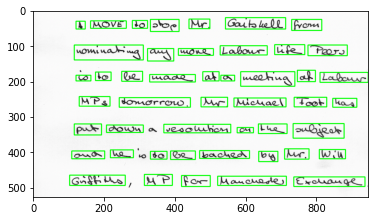

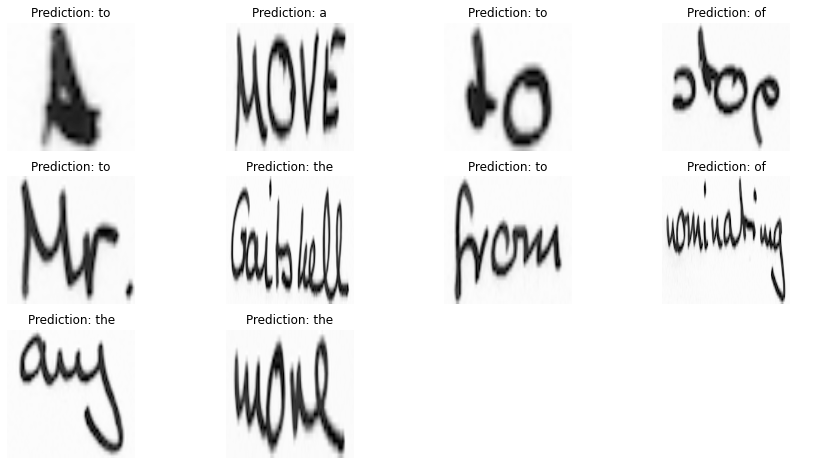

to a to of to the to of the the to the to of to the of of a of of to the of to to to the a to to a the to of the to the to of to to to of to to to


In [51]:
image_path = '/samples/sample1.png'
sound_file,predictions = recognize(final_model,image_path,IMAGE_SIZE=IMAGE_SIZE,show_sample=10,engine_type='gtts')
print(" ".join(predictions))
Audio(sound_file, autoplay=False,)
# Not so good prediction because we don't have enough training images for some words

In [ ]:
# testing on forms using list 1

final_model = svm_poly
for f in form_names:
  image_path = "/forms/"+f+".png"
  sound_file,predictions = recognize(final_model,image_path,IMAGE_SIZE,show_sample=20, forms=True)
  print(" ".join(predictions))
  Audio(sound_file, autoplay=False)

In [ ]:
# testing on forms we used to get training words
form_predictions = []
final_model = svm_poly

for f in form_names:
  print(f)
  image_path = "/forms/"+f+".png"
  sound_file,predictions = recognize(final_model,image_path,IMAGE_SIZE,show_sample=20, forms=True)
  print(" ".join(predictions))
  # form_predictions = form_predictions+list(predictions)
  form_predictions.append(list(predictions))
  Audio(sound_file, autoplay=False)

In [ ]:
# trying to get words bounding boxes to match with labels
bb_list = []
for f in form_names:
  image_path = "/forms/"+f+".png"
  bounding_boxes = get_bounding_box_from_image(image_path, forms=True)
  bb_list.append(bounding_boxes)

In [ ]:
x,y,w,h = bb_list[0][0] # [336, 271, 466, 348]

In [ ]:
# checking how many words were labeled correctly
# still need to find a way to map the predicted word to the correct label

for i, f in enumerate(form_names):
  # image_path = "/forms/"+f+".png"
  # img = read_image(image_path, color=True)
  # for ii in range(len(bb_list[i])):
  #   x,y,w,h = bb_list[i][ii]
  #   cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0),2) # 670:2700 (need to add back this part that was cropped)
  # show_image(img)
  print("Form ",f)
  print("Number of predictions: ",len(form_predictions[i]))
  print("Number of Words: ",len(form_labels[i]))
  c=0
  for w in range(len(form_predictions[i])):
    c += form_predictions[i][w]==form_labels[i][w]
  print("Number of correct predictions: ", c)


## Showing the process for the presentation

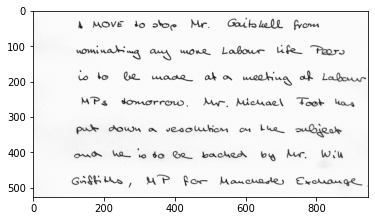

In [ ]:
img = read_image(image_path, color=True)
show_image(img)

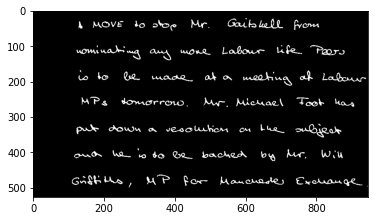

In [ ]:
# threshold image
thresh_img = thresholding(img);
show_image(thresh_img)

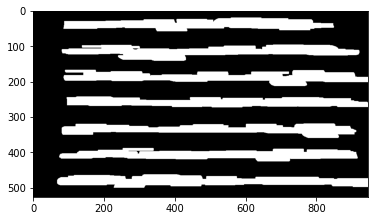

In [ ]:
# find bounding boxes for lines
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
show_image(dilated)

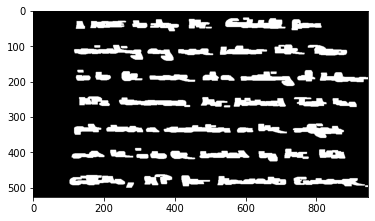

In [ ]:
# find bounding boxes for words
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
show_image(dilated2)

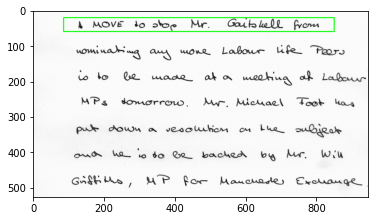

In [ ]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
line = sorted_contours_lines[0]
x, y, w, h = cv2.boundingRect(line)
roi_line = dilated2[y:y+h, x:x+w]
img = read_image(image_path, color=True)
cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0),2)
show_image(img)

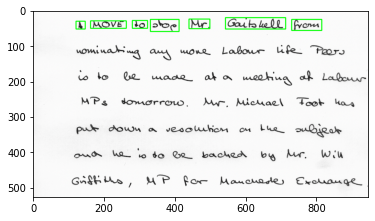

In [ ]:
img = read_image(image_path, color=True)

# draw contours on each word
(cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
for word in sorted_contour_words:
        if cv2.contourArea(word) < 400:
            continue
        x2, y2, w2, h2 = cv2.boundingRect(word)
        cv2.rectangle(img, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0, 255, 0),2)
show_image(img)

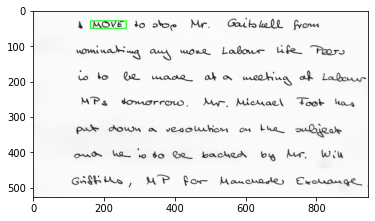

In [ ]:
img = read_image(image_path, color=True)
cv2.rectangle(img, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0, 255, 0),2)
show_image(img)

### Trying python package on same image

In [ ]:
# !pip install easyocr
import easyocr

In [ ]:
# Tryin a easyocr library

image_path = '/samples/sample1.png'

reader = easyocr.Reader(['en'],gpu = False) # load once only in memory.

image_file_name=image_path
image = cv2.imread(image_file_name)

# sharp the edges or image.
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
r_easy_ocr=reader.readtext(thresh,detail=0)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
" ".join(r_easy_ocr)

'4 MOVE Jo Mr . Gaibhe Q Fver uomi w3 axf MonQ_ Labowv Lfe- Frs io lo Qsq_ luade_ 0t 0 weeka a8 Lc bcusn " MPg vonorroio Av , Auclae ( Tcot doujm 0 vejoluhio  C4 Lhe _ ouQieak 040 6a _ 1 00 Gbr _ baakea bd Ar: W ,U Gvee Por Mououaate_ Exclaaqe _ 3p6 uak: LaLa Put 47p U'